# Notebook #5: Series temporales: predicción a futuro de la población

In [1]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
from prophet import Prophet

# Importar las clases
# -----------------------------------------------------------------------
import sys
sys.path.append('../..')
from src import soporte_funciones_BBDD as sfbd
from src import soporte_sarima as ss
from src import soporte_temporales as st
from src import soporte_variables_poblacion as svp

# Modelo Series Temporales
# -----------------------------------------------------------------------
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA


# Visualizar las métricas de error en y_test
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
# Configuraciones
# -----------------------------------------------------------------------
pd.options.display.float_format = '{:.0f}'.format
from itertools import product

%load_ext autoreload
%autoreload 2

In [2]:
df_poblacion = sfbd.dbeaver_fetch(sfbd.dbeaver_conexion("proyecto_final"),svp.query_poblacion)

In [5]:
df_poblacion.columns = ['FECHA', 'Población']
df_poblacion['FECHA'] = pd.to_datetime(df_poblacion['FECHA'].astype(str) + '-12-31')

In [6]:
# instanciamos la clase
analisis_st = st.TimeSeriesAnalysis(df_poblacion, temporal_column="FECHA", value_column="Población")

analisis_st.exploracion_datos()

El número de filas es 64 y el número de columnas es 1

----------

No hay duplicados

----------

No hay valores nulos

----------

Estadísticas de las variables numéricas:


,count,mean,std,min,25%,50%,75%,max
Población,64,7329201,2478189,3268336,5146997,7373664,9485026,11331265


In [7]:
analisis_st.comprobar_serie_continua('A')

La serie temporal es continua para la frecuencia 'A', no faltan periodos.


In [8]:
analisis_st.graficar_serie()

## Análisis de la serie temporal del parque vehicular

- Se puede observar una tendencia en ascenso, lo que indica que ha tenido un crecimiento uniforme en el transcurso del tiempo. Sin embargo, entre el 1990-2000 esta línea que muestra un ascenso casi lineal empieza a mostrar un cambio en su fuerza de aumento. Lo cuál queda más claro a partir del 2010.

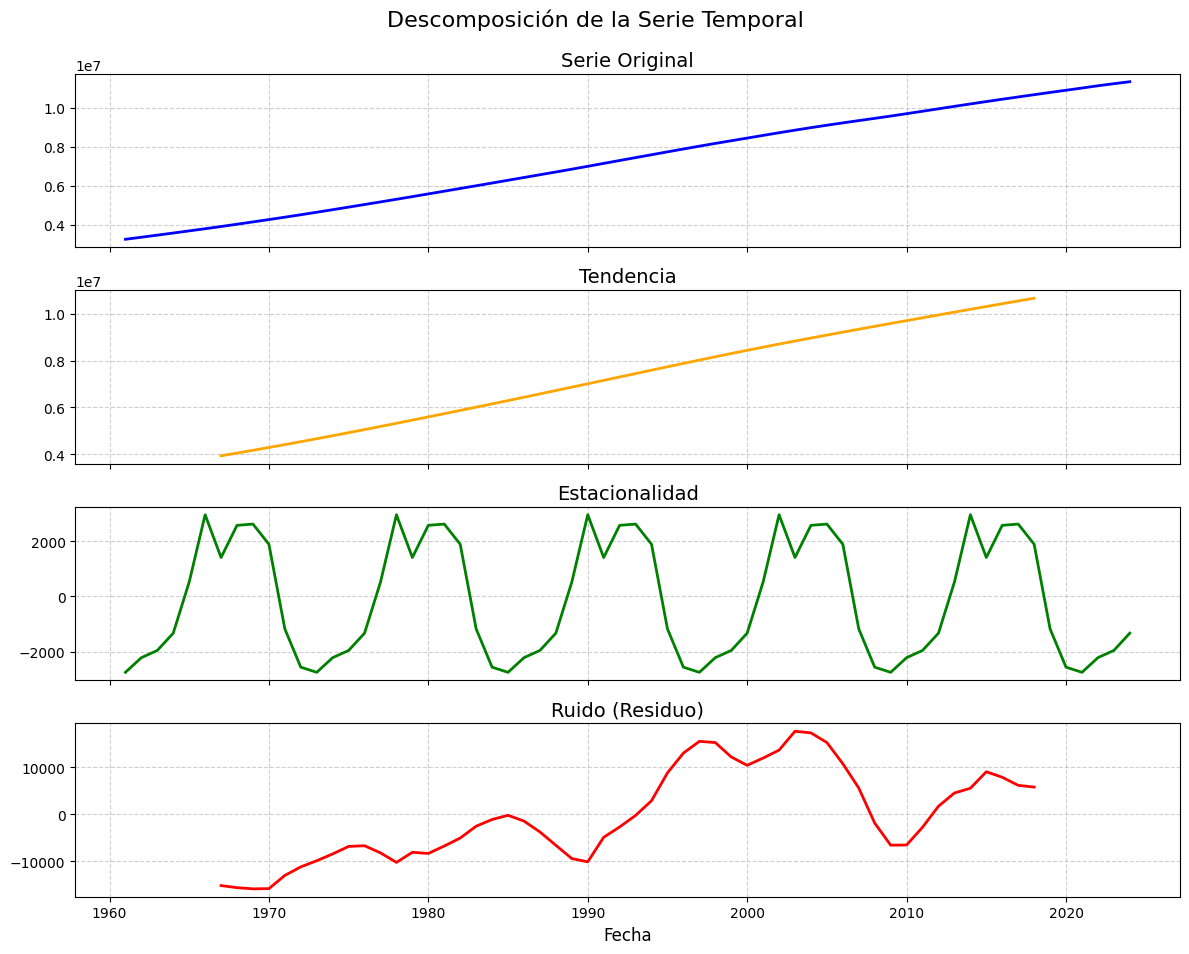

In [9]:
analisis_st.detectar_estacionalidad()

<Figure size 1200x1000 with 0 Axes>

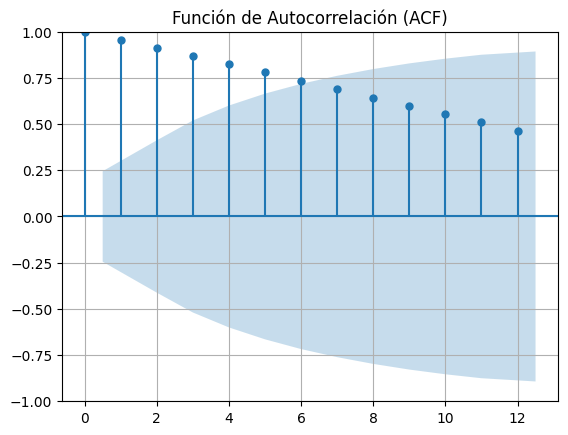

<Figure size 1200x1000 with 0 Axes>

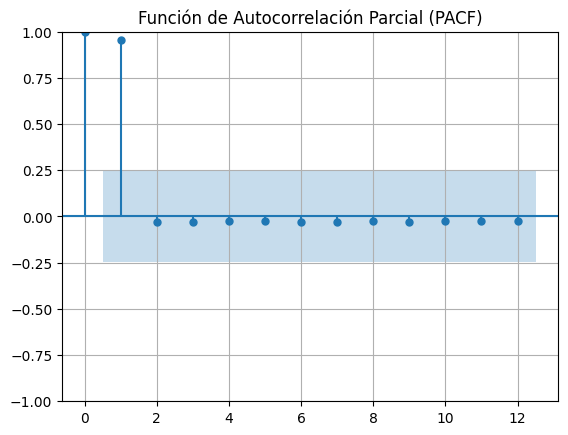

In [10]:
analisis_st.graficar_acf_pacf(lags=12)

## Análisis de las gráficas ACF y PACF

### **Gráfica ACF (Función de Autocorrelación)**
1. **Lag 1**:
   - La correlación en el primer lag es muy alta, lo que indica que la variable tiene una fuerte relación con su valor del periodo inmediatamente anterior.
   
2. **Lags significativos**:
   - Hasta el lag número 6 tienen correlaciones significativas que sobresalen del intervalo de confianza, lo que sugiere que también tienen impacto en la serie.
   - Después del sexto lag, las correlaciones se adentran al intervalo de confianza.

3. **Estacionalidad**:
   - No tiene estacionalidad ya que son datos anuales   
---

### **Gráfica PACF (Función de Autocorrelación Parcial)**
1. **Lag 1**:
   - El primer lag muestra una correlación significativa, indicando que el valor actual está altamente influenciado por el valor del periodo inmediatamente anterior.

2. **Lags significativos**:
   - El segundo lag también tiene una fuerte conexión, sin embargo pasado este todos caen dentro del intervalo de confianza. De manera que los lags más lejanos no tienen influencia directa significativa.
---

In [11]:
analisis_st.prueba_estacionariedad()

ADF Statistic: -3.7268586635941947
p-value: 0.0037508380967098305
Valores Críticos:
1%: -3.548493559596539
5%: -2.912836594776334
10%: -2.594129155766944
Rechazamos la hipótesis nula. La serie es estacionaria.


In [12]:
modelo_arima = st.ARIMAModel()

parametros_arima = modelo_arima.generar_parametros(p_range=range(1,6), q_range=range(1,6))
parametros_arima[:5]

[(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]

In [13]:
train_size= int(0.7 * len(df_poblacion))
df_poblacion.set_index('FECHA', inplace=True)
df_poblacion.index = pd.to_datetime(df_poblacion.index)
df_poblacion = df_poblacion.asfreq('A')

y_train, y_test = df_poblacion[:train_size], df_poblacion[train_size:]

In [14]:
resultados_arima = modelo_arima.evaluar_modelos(y_train, y_test, parametros_arima, diferenciacion=1)
resultados_arima.head(3)

  0%|          | 0/25 [00:00<?, ?it/s]C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

  4%|▍         | 1/25 [00:00<00:05,  4.12it/s]C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

  8%|▊         | 2/25 [00:00<00:04,  4.96it/s]C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 12%|█▏        | 3/25 [00:00<00:05,  4.16it/s]C:\Users\DELL\AppData\Local\Packages\Pyth

,p,q,RMSE,error
0,1,1,157572,NaN
1,1,2,162829,NaN
2,1,3,164911,NaN


In [15]:
resultados_arima.sort_values(by='RMSE', ascending=True).head()

,p,q,RMSE,error
0,1,1,157572,NaN
6,2,2,158783,NaN
12,3,3,159444,NaN
3,1,4,161879,NaN
1,1,2,162829,NaN


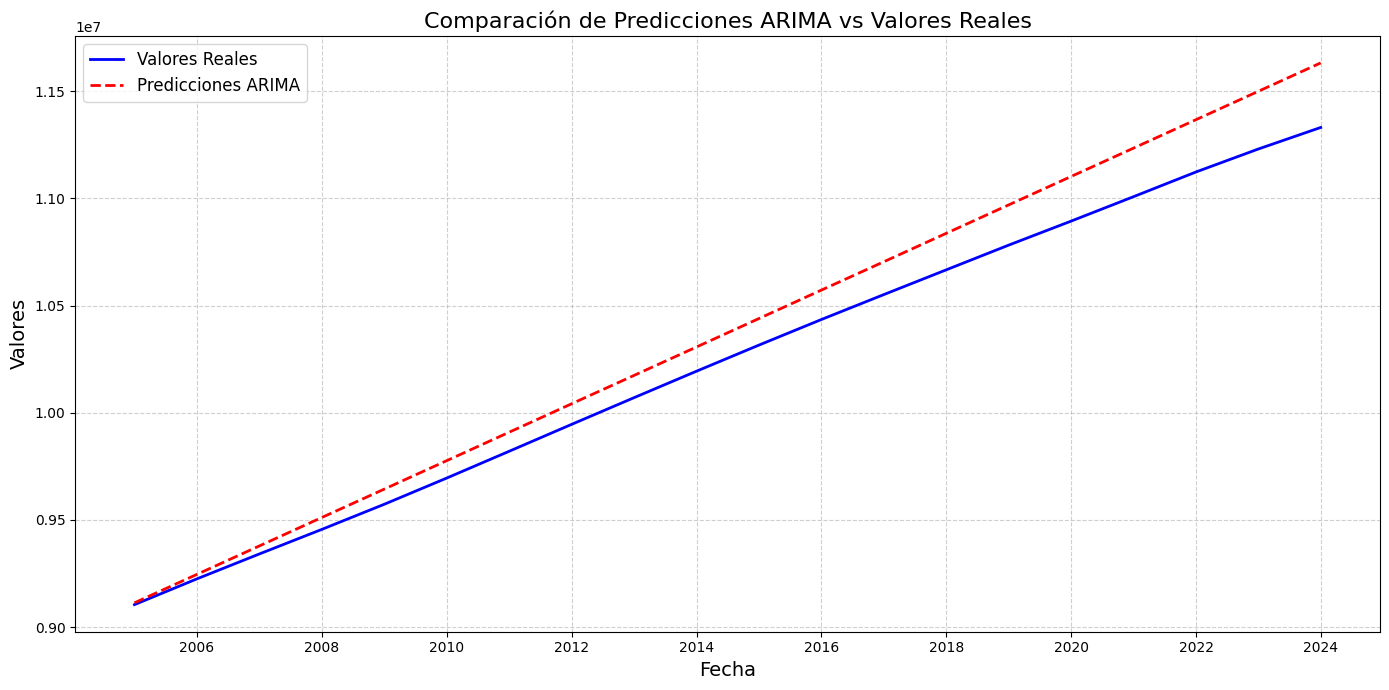

In [16]:
modelo_arima.visualizar_predicciones(y_test)

In [17]:
modelo_arima.best_model['pred_test']

FECHA
2004-12-31    9113271
2005-12-31    9245916
2006-12-31    9378556
2007-12-31    9511189
2008-12-31    9643815
2009-12-31    9776436
2010-12-31    9909051
2011-12-31   10041660
2012-12-31   10174262
2013-12-31   10306859
2014-12-31   10439449
2015-12-31   10572034
2016-12-31   10704612
2017-12-31   10837184
2018-12-31   10969751
2019-12-31   11102311
2020-12-31   11234865
2021-12-31   11367413
2022-12-31   11499955
2023-12-31   11632491
Freq: A-DEC, Name: predicted_mean, dtype: float64

In [18]:
modelo_arima.best_params

{'p': 1, 'q': 1}

### Métricas para el y_test

In [19]:
# Calcular métricas
mae = mean_absolute_error(y_test, modelo_arima.best_model["pred_test"])
mape = mean_absolute_percentage_error(y_test, modelo_arima.best_model["pred_test"])
rmse = np.sqrt(mean_squared_error(y_test, modelo_arima.best_model["pred_test"]))

print(f"MAE: {mae}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"RMSE: {rmse}")

MAE: 134868.86458969506
MAPE: 1.27%
RMSE: 157571.61838349255


A pesar de que el valor de MAPE es bastante bueno, los valores del MAE y RMSE se mantienen alto. Esto pudiera venir dado por algún residuo signifivativo en algún momento.

## Métricas para el conjunto completo

In [20]:
# Predicción para todo el rango del conjunto histórico
pred_todo = modelo_arima.best_model["modelo"].predict(start=0, end=len(y_test) + len(y_train) - 1)
pred_df = pd.DataFrame({
    "Fecha": pd.concat([y_train, y_test]).index,
    "Valor Real": pd.concat([y_train, y_test])["Población"],
    "Predicción": pred_todo
})
pred_df.tail(5)

,Fecha,Valor Real,Predicción
2019-12-31,2019-12-31,10894043,11102311
2020-12-31,2020-12-31,11008300,11234865
2021-12-31,2021-12-31,11123476,11367413
2022-12-31,2022-12-31,11230734,11499955
2023-12-31,2023-12-31,11331265,11632491


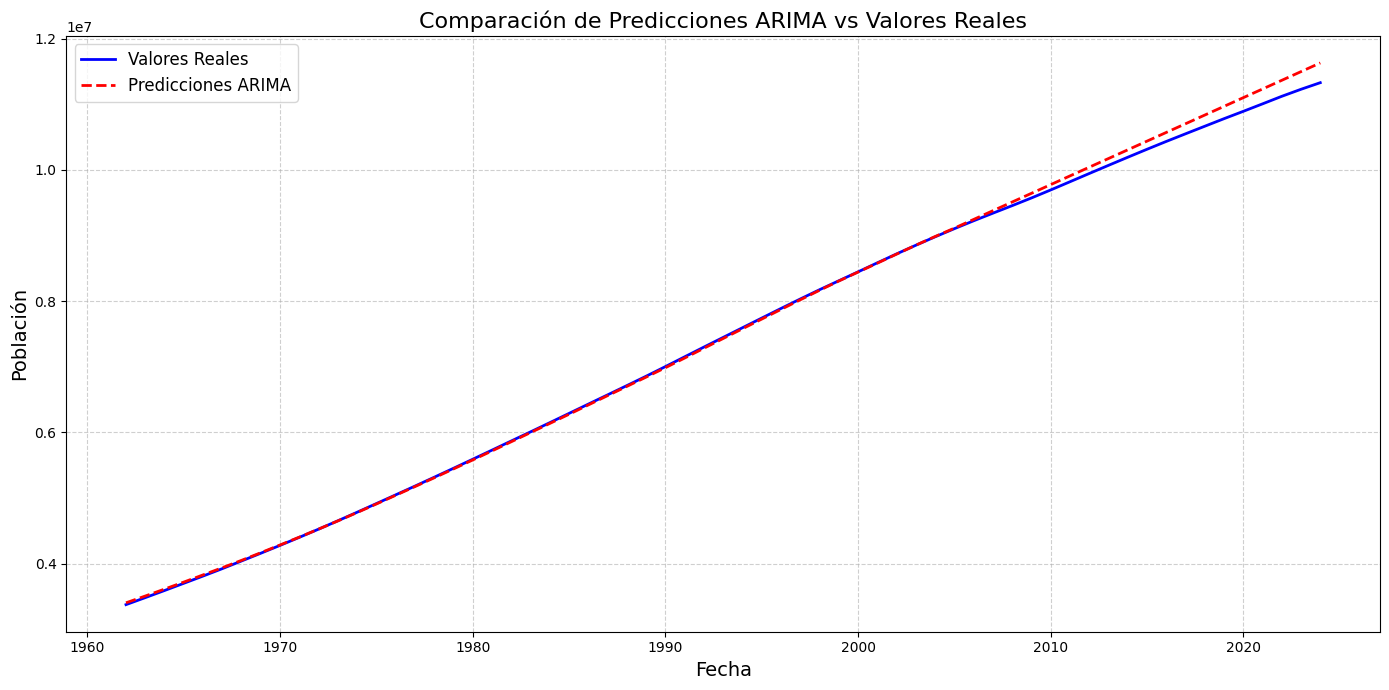

In [21]:
# Configuración de la figura
plt.figure(figsize=(14, 7))

# Graficar valores reales
sns.lineplot(data=pred_df[1:], x="Fecha", y="Valor Real", label="Valores Reales", color="blue", linewidth=2)

# Graficar predicciones
sns.lineplot(data=pred_df[1:], x="Fecha", y="Predicción", label="Predicciones ARIMA", color="red", linestyle="--", linewidth=2)

# Personalización de la gráfica
plt.title("Comparación de Predicciones ARIMA vs Valores Reales", fontsize=16)
plt.xlabel("Fecha", fontsize=14)
plt.ylabel("Población", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

# Mostrar la gráfica
plt.show()

    - Se puede apreciar que el modelo registra bastante bien el comportamiento de los datos. Sigue su tendencia a lo largo de los años. Sin embargo, a partir del 2010 se empieza a visualizar una diferencia notable en cuánto a las predicciones en comparación con lo real. De manera que el residuo deja ver unas diferencias claras.

In [22]:
# Calcular métricas
mae_todo = mean_absolute_error(pred_df["Valor Real"], pred_df["Predicción"])
mape_todo = mean_absolute_percentage_error(pred_df["Valor Real"], pred_df["Predicción"])
rmse_todo = np.sqrt(mean_squared_error(pred_df["Valor Real"], pred_df["Predicción"]))

# Mostrar resultados
print(f"MAE para toda la serie: {mae_todo}")
print(f"MAPE para toda la serie: {mape_todo * 100:.2f}%")
print(f"RMSE para toda la serie: {rmse_todo}")

MAE para toda la serie: 100694.72032540414
MAPE para toda la serie: 2.10%
RMSE para toda la serie: 418061.1994508306


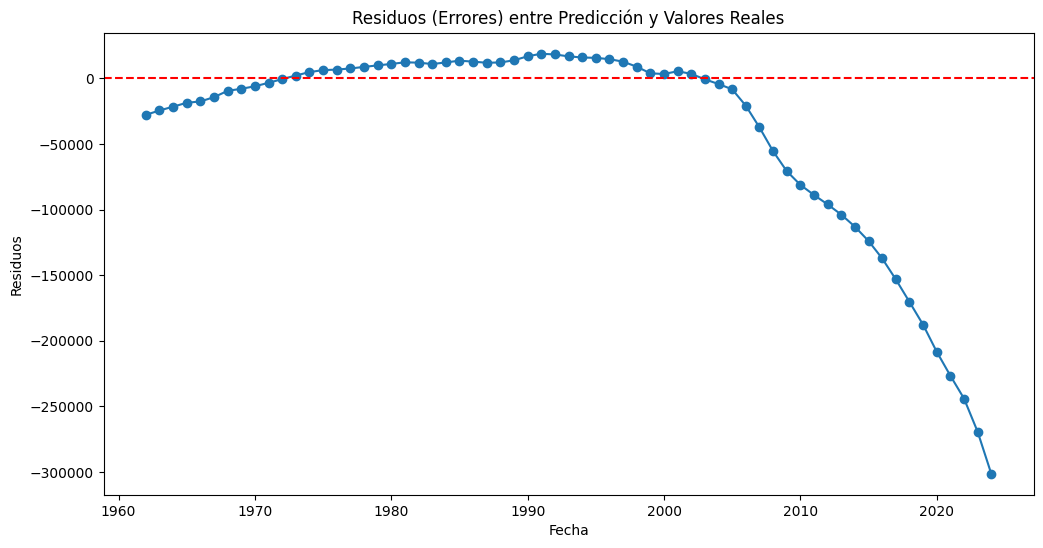

In [23]:
residuos = pred_df["Valor Real"] - pred_df["Predicción"]
plt.figure(figsize=(12, 6))
plt.plot(pred_df["Fecha"][1:], residuos[1:], marker='o')
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuos (Errores) entre Predicción y Valores Reales")
plt.xlabel("Fecha")
plt.ylabel("Residuos")
plt.show()

Nos damos cuenta que el modelo empieza con unos valores muy distantes de los valores reales. Esto genera el problema ya que el modelo al principio necesita estimar los valores iniciales. De esta forma, este residuo es lo que eleva mi RMSE a pesar de que el MAPE es sumamente confiable.

## Métricas sin incluir el primer año

In [24]:
mae = mean_absolute_error(pred_df["Valor Real"][1:], pred_df["Predicción"][1:])
mape = mean_absolute_percentage_error(pred_df["Valor Real"][1:], pred_df["Predicción"][1:])
rmse = np.sqrt(mean_squared_error(pred_df["Valor Real"][1:], pred_df["Predicción"][1:]))

print(f"MAE: {mae}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"RMSE: {rmse}")

MAE: 50414.70001310898
MAPE: 0.55%
RMSE: 89406.37083804571


## Aplicar mejores parámetros y predecir

In [25]:
mejor_modelo_arima = ARIMA(
    pd.concat([y_train, y_test]),  # Usar toda la serie
    order=(modelo_arima.best_params['p'], 2, modelo_arima.best_params['q'])  # Incluir el parámetro d=2 
).fit()

print(mejor_modelo_arima.summary())

                               SARIMAX Results                                
Dep. Variable:              Población   No. Observations:                   64
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -584.449
Date:                Fri, 31 Jan 2025   AIC                           1174.899
Time:                        16:37:31   BIC                           1181.280
Sample:                    12-31-1960   HQIC                          1177.404
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2716      1.686     -0.161      0.872      -3.576       3.033
ma.L1          0.2711      1.689      0.161      0.872      -3.038       3.581
sigma2      3.409e+06   9.41e-07   3.62e+12      0.0

Utilicé el parámetro, d=2, porque al utilizar 1 como valor todas las predicciones eran iguales.

In [26]:
# Predecir los próximos 2 años (por ejemplo)
predicciones_futuras = mejor_modelo_arima.predict(start=len(y_train) + len(y_test), 
                                                  end=len(y_train) + len(y_test) + 2)
print(predicciones_futuras)

2024-12-31   11431798
2025-12-31   11532331
2026-12-31   11632864
Freq: A-DEC, Name: predicted_mean, dtype: float64


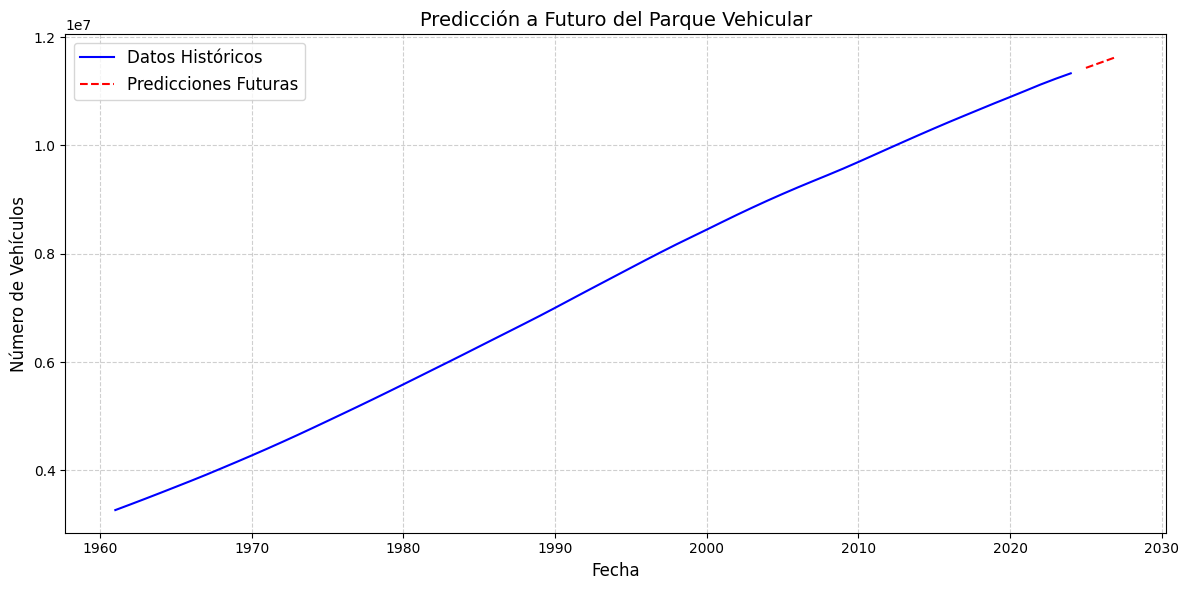

In [27]:
# Crear un rango de fechas para las predicciones futuras
fechas_futuras = pd.date_range(start=y_test.index[-1] + pd.DateOffset(1), periods=len(predicciones_futuras), freq='A')

# Crear un DataFrame para las predicciones futuras
predicciones_df = pd.DataFrame({
    'Fecha': fechas_futuras,
    'Predicción': predicciones_futuras
})

# Unir las predicciones futuras con los datos históricos
datos_historicos_df = pd.concat([y_train, y_test])
datos_historicos_df = pd.DataFrame(datos_historicos_df).reset_index()
datos_historicos_df.columns = ['Fecha', 'Valor Real']

# Graficar los datos
plt.figure(figsize=(12, 6))

# Graficar datos históricos
plt.plot(datos_historicos_df['Fecha'], datos_historicos_df['Valor Real'], label='Datos Históricos', color='blue')

# Graficar predicciones futuras
plt.plot(predicciones_df['Fecha'], predicciones_df['Predicción'], label='Predicciones Futuras', color='red', linestyle='--')

# Personalizar el gráfico
plt.title('Predicción a Futuro del Parque Vehicular', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Número de Vehículos', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Mostrar el gráfico
plt.show()